# Toggle model

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import dynamo as dyn
dyn.get_all_dependencies_version()

2023-12-01 00:02:24.316222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 00:02:25.879893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


package    tqdm statsmodels setuptools   scipy scikit-learn pandas   numpy  \
version  4.65.0      0.14.0     68.0.0  1.10.0        1.2.2  1.5.3  1.22.3   

package networkx matplotlib anndata  igraph loompy numdifftools umap-learn  \
version    2.8.4      3.7.1   0.9.1  0.10.4  3.0.7       0.9.41      0.5.3   

package   numba seaborn colorcet pynndescent pre-commit get-version openpyxl  \
version  0.56.4  0.12.2    3.0.1       0.5.8      3.2.0       3.5.4  3.2.0b1   

package typing-extensions session-info dynamo-release  
version             4.5.0        1.0.0          1.3.3

## Generate toggle model simulation data

In [3]:
adata=dyn.sim.Simulator(motif='toggle',
                 seed_num=19491001,
                 clip=None,
                 cell_num=5000)

In [4]:
adata.obsm['X_umap'], adata.obsm['velocity_umap'] = adata.X, adata.layers['velocity']
adata.obs['ntr'] = 0
adata.var['use_for_pca'] = True
adata.var['use_for_dynamics'] = True
adata.var['use_for_transition'] = True

a = np.zeros((2, 2), int)
np.fill_diagonal(a, 1)
adata.uns['PCs'] = a
adata.var['gamma'] = 1

X = adata.X
adata.obsm["X_pca"] = adata.obsm["X_umap"]
adata.obsm['velocity_pca'] = adata.obsm['velocity_umap'].copy()
adata.layers['velocity_S'] = adata.layers['velocity'].copy()

## Reconstruct vector field

In [5]:
dyn.vf.VectorField(adata, basis='umap')
dyn.vf.VectorField(adata, basis='pca')

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [1.2307s]
|-----> [VectorField] completed [1.4796s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [0.8049s]
|-----> [VectorField] completed [1.0361s]


## Visualizing RNA velocity

|-----------> plotting with basis key=X_umap


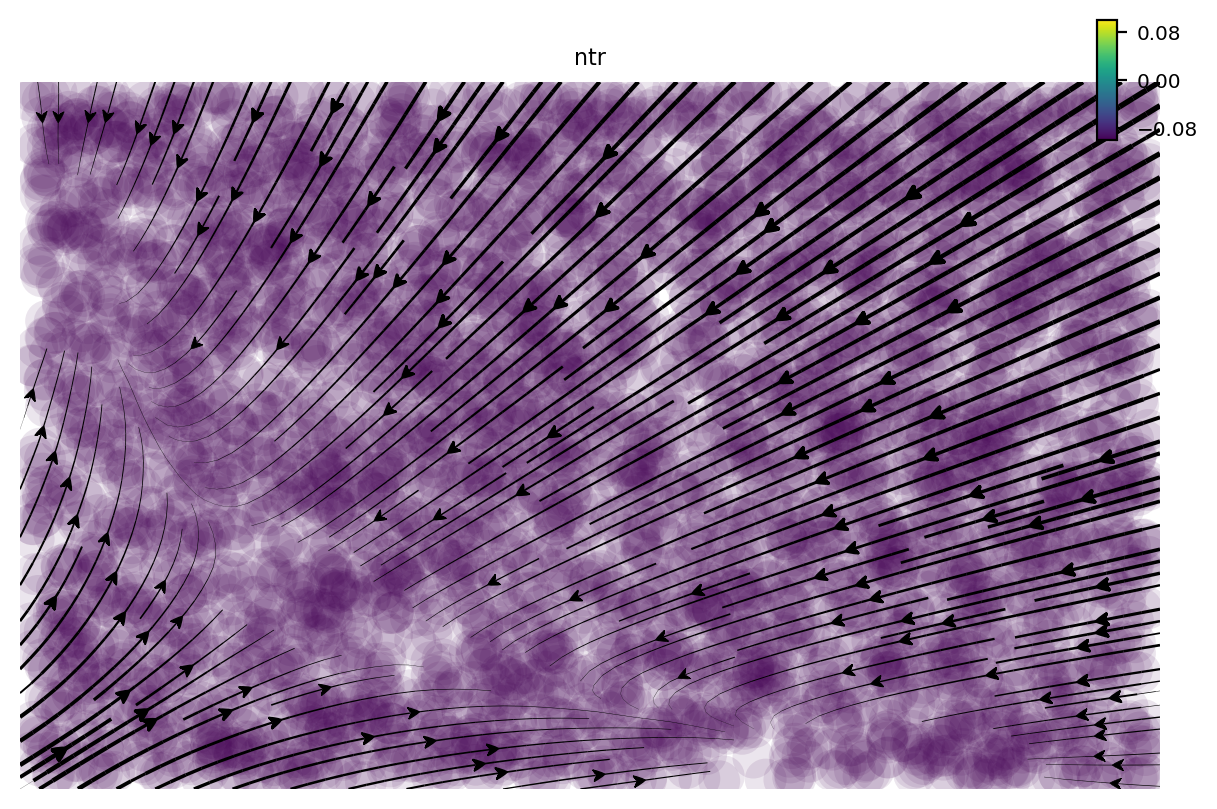

In [6]:
dyn.pl.streamline_plot(adata, color=['ntr'], basis='umap')

## Characterize vector field topology

|-----> Vector field for umap is but its topography is not mapped. Mapping topography now ...
|-----------> plotting with basis key=X_umap


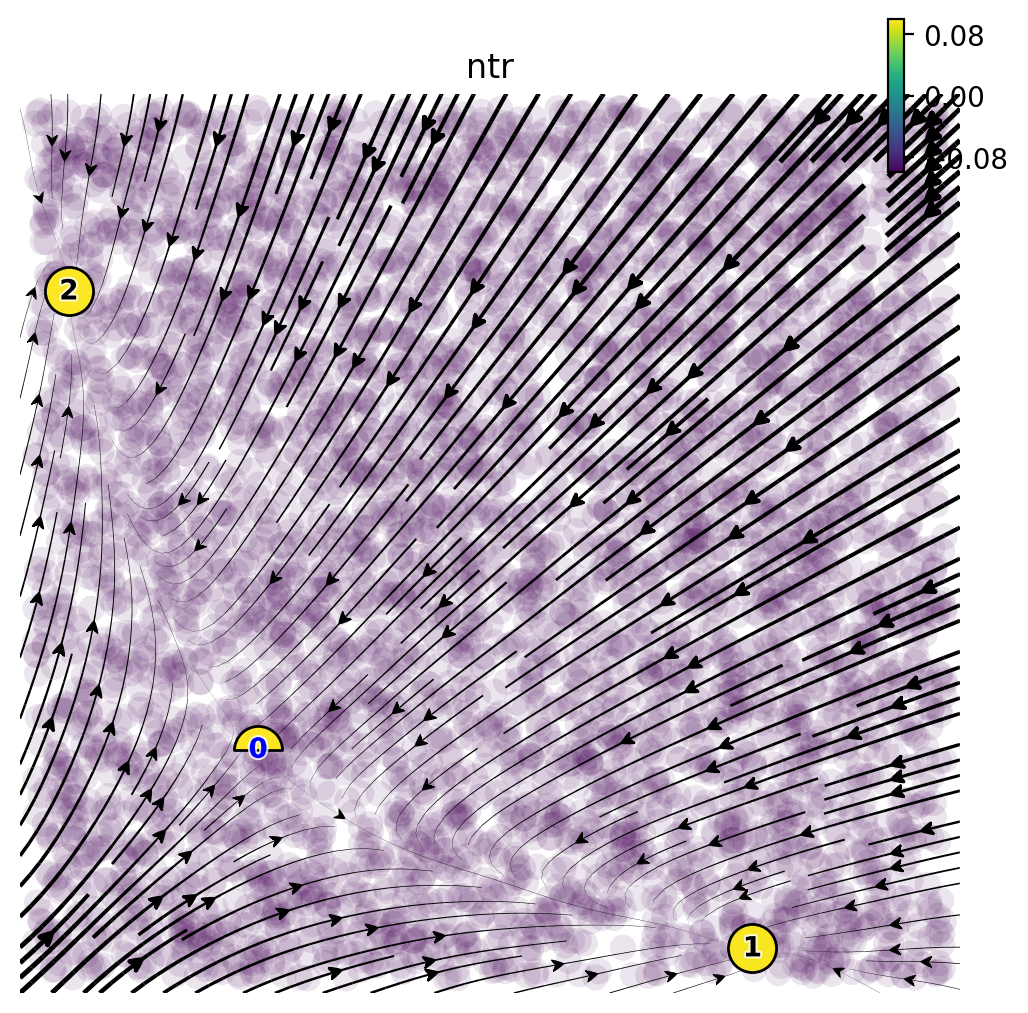

In [7]:
dyn.pl.topography(
        adata, markersize=300, 
        basis="umap", 
        save_show_or_return="show", 
        fps_basis="umap", 
        color="ntr",
        pointsize=0.4,
        streamline_alpha=1, 
        frontier=False,
        xlim=([-0.1,6.1]),
        ylim=(-0.1,6.1),
        figsize=(5,5),
    )

In [8]:
adata.uns['dynamics'] = {}
adata.uns['dynamics']["use_smoothed"] = True
adata.uns['dynamics']["has_splicing"] = True
adata.uns['dynamics']["has_labeling"] = False
adata.uns['dynamics']["NTR_vel"] = False
dyn.tl.neighbors(adata, basis='umap')
adata.uns['dynamics']["est_method"] = 'ols'
adata.var["use_for_transition"] = True
adata.uns['dynamics']['experiment_type'] = None
adata.layers['M_s'], adata.layers['M_u'] = adata.X.copy(), adata.X.copy()

|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:umap
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


In [9]:
adata.uns['VecFld_umap']['Xss']

array([[1.47074133, 1.57712828],
       [4.73087644, 0.20759548],
       [0.22273542, 4.73670019]])

## Least action path predictions

In [10]:
from dynamo.tools.utils import nearest_neighbors

fixed_points = np.array(
    [
        [4.73087644, 0.20759548],
        [0.22273542, 4.73670019],
    ]
)

A_cells_indices = nearest_neighbors(fixed_points[0], adata.obsm["X_umap"])
B_cells_indices = nearest_neighbors(fixed_points[1], adata.obsm["X_umap"])

### Run pairwise least action path analyses among distinct cell types

|-----> searching for the least action path...
|-----> [iterating through 1 pairs] in progress: 100.0000%|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: 20.769019
|-----> [iterating through 1 pairs] completed [14.1120s]
|-----> [least action path] completed [14.1135s]


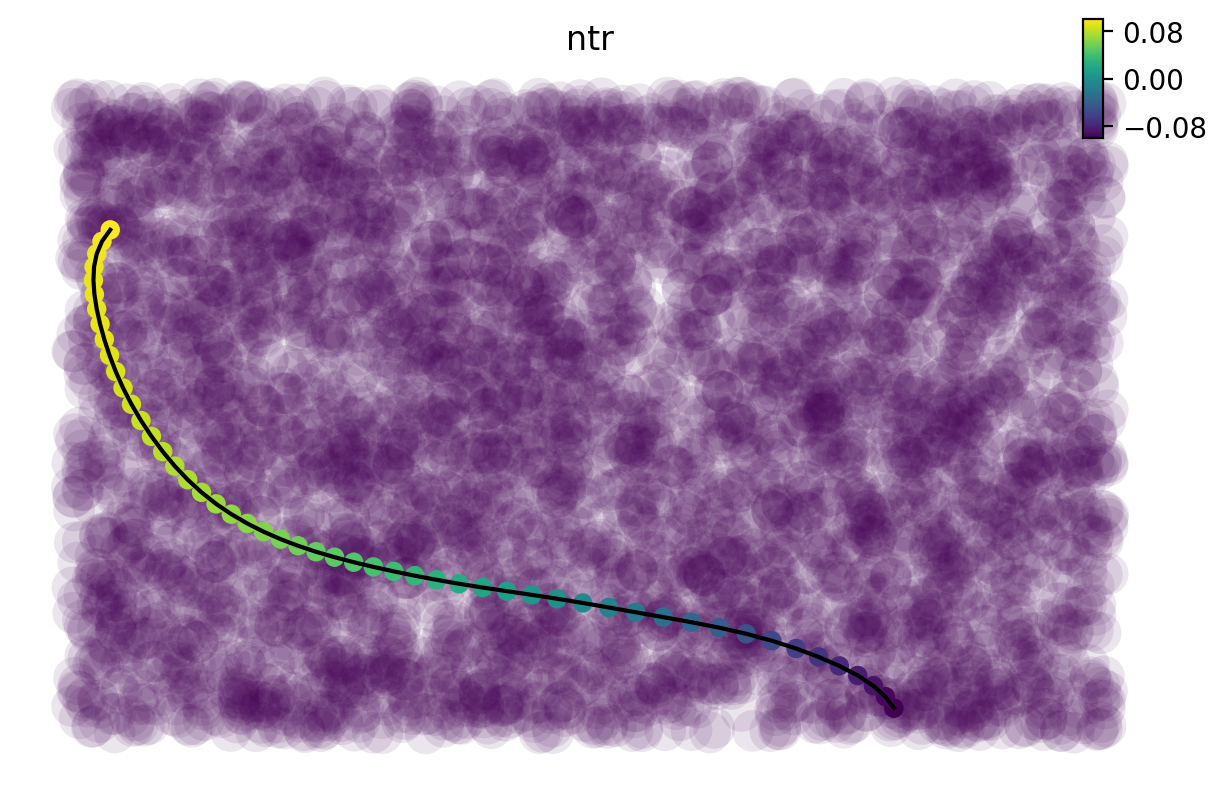

[[2462 2737 3126 4221 2757]] -> [[1167 1106 4189 3223   85]]
|-----> searching for the least action path...
|-----> [iterating through 1 pairs] in progress: 100.0000%|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: 20.491955
|-----> [iterating through 1 pairs] completed [0.7917s]
|-----> [least action path] completed [0.7928s]


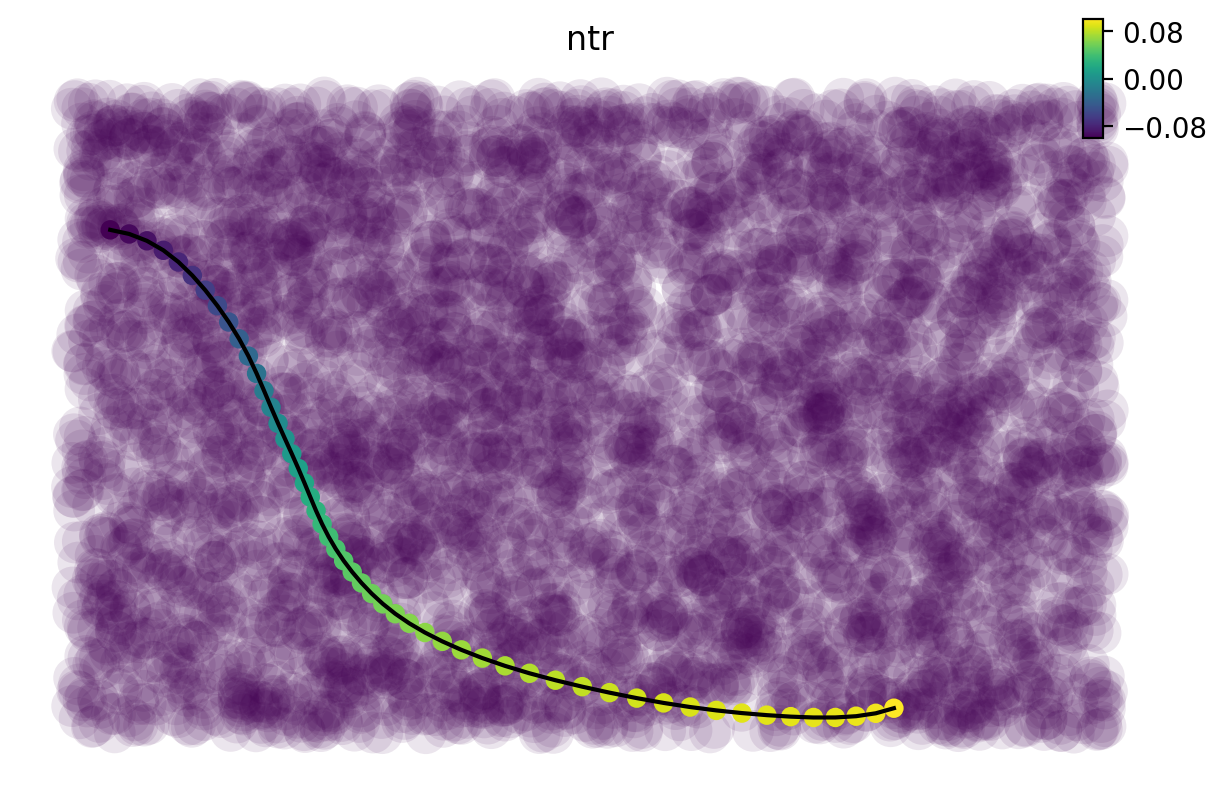

[[1167 1106 4189 3223   85]] -> [[2462 2737 3126 4221 2757]]


In [18]:
import matplotlib.pyplot as plt
dyn.dynamo_logger.main_silence()
transition_graph = {}
cell_type = ["A", "B"]
start_cell_indices = [
    A_cells_indices,
    B_cells_indices,
]
end_cell_indices = start_cell_indices
for i, start in enumerate(start_cell_indices):
    for j, end in enumerate(end_cell_indices):
        if start is not end:
            min_lap_t = True if i == 0 else False
            dyn.pd.least_action(
                adata,
                [adata.obs_names[start[0]][0]],
                [adata.obs_names[end[0]][0]],
                basis="umap",
                adj_key="distances",
                min_lap_t= min_lap_t,
                EM_steps=1,
                D=0.1,
                n_points=50
            )
            dyn.pl.least_action(adata, basis="umap") 

            print(start, "->", end)
            
            transition_graph[cell_type[i] + "->" + cell_type[j]] = {
                "LAP_umap": adata.uns["LAP_umap"],    
            }

### Visualize LAPs

In [22]:
from dynamo.plot.utils import map2color
def plot_savelap(paths):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = dyn.pl.topography(
        adata, markersize=500, 
        basis="umap", 
        save_show_or_return="return", 
        ax=ax, 
        fps_basis="umap", 
        color="ntr",
        pointsize=0.4,
        streamline_alpha=1, 
        frontier=False,
        xlim=([-0.1,6.1]),
        ylim=(-0.1,6.1),
        figsize=(5,5),
    )
    #ax = ax[0]
    x, y = 0, 1

    # plot paths
    for path in paths:
        lap_dict = transition_graph[path]["LAP_umap"]
        for prediction, action in zip(lap_dict["prediction"], lap_dict["action"]):
            ax.scatter(*prediction[:, [x, y]].T, c=map2color(action))
            ax.plot(*prediction[:, [x, y]].T, c="k")
    plt.savefig('/home/datadisk/zlg/singlecell/stemcell_cycle_differentiation/figure/toggle_LAP.pdf') 

In [23]:
plot_savelap(["A->B", "B->A"])

### Save LAPs

In [21]:
transition_graph["A->B"]['LAP_umap']['prediction']

[array([[4.75927026, 0.23688076],
        [4.71052223, 0.34611974],
        [4.64020032, 0.44906357],
        [4.5500819 , 0.54565032],
        [4.44325261, 0.63618467],
        [4.32321467, 0.72108487],
        [4.19269296, 0.8003752 ],
        [4.05297365, 0.87336138],
        [3.90443704, 0.93899894],
        [3.74800557, 0.99694966],
        [3.5863815 , 1.04850357],
        [3.42380445, 1.09621525],
        [3.26413673, 1.14226716],
        [3.1089845 , 1.18718832],
        [2.9577033 , 1.23010688],
        [2.80896114, 1.26998504],
        [2.66220373, 1.30671325],
        [2.51802929, 1.34138214],
        [2.37762464, 1.37569835],
        [2.24196968, 1.41111038],
        [2.11138817, 1.44831368],
        [1.9855927 , 1.48734337],
        [1.86402923, 1.5280049 ],
        [1.74622251, 1.57030235],
        [1.63192805, 1.61466366],
        [1.52107844, 1.66192881],
        [1.41364034, 1.71318497],
        [1.30951131, 1.76957926],
        [1.20851724, 1.83220796],
        [1.110

In [50]:
path_A_B = np.array([[4.75927026, 0.23688076],
        [4.71052223, 0.34611974],
        [4.64020032, 0.44906357],
        [4.5500819 , 0.54565032],
        [4.44325261, 0.63618467],
        [4.32321467, 0.72108487],
        [4.19269296, 0.8003752 ],
        [4.05297365, 0.87336138],
        [3.90443704, 0.93899894],
        [3.74800557, 0.99694966],
        [3.5863815 , 1.04850357],
        [3.42380445, 1.09621525],
        [3.26413673, 1.14226716],
        [3.1089845 , 1.18718832],
        [2.9577033 , 1.23010688],
        [2.80896114, 1.26998504],
        [2.66220373, 1.30671325],
        [2.51802929, 1.34138214],
        [2.37762464, 1.37569835],
        [2.24196968, 1.41111038],
        [2.11138817, 1.44831368],
        [1.9855927 , 1.48734337],
        [1.86402923, 1.5280049 ],
        [1.74622251, 1.57030235],
        [1.63192805, 1.61466366],
        [1.52107844, 1.66192881],
        [1.41364034, 1.71318497],
        [1.30951131, 1.76957926],
        [1.20851724, 1.83220796],
        [1.11049693, 1.90210627],
        [1.01542052, 1.98028968],
        [0.92348214, 2.06775872],
        [0.83511151, 2.1653878 ],
        [0.75086762, 2.27368986],
        [0.67123288, 2.39256386],
        [0.59642446, 2.52120392],
        [0.526391  , 2.65826552],
        [0.46105067, 2.80217151],
        [0.400596  , 2.95132346],
        [0.34558089, 3.10410755],
        [0.29667513, 3.25880648],
        [0.25427072, 3.41360311],
        [0.21825781, 3.56674797],
        [0.18814834, 3.71680778],
        [0.16346613, 3.86284815],
        [0.1441735 , 4.00445264],
        [0.1309353 , 4.14157107],
        [0.12515578, 4.27426102],
        [0.12884781, 4.40240219],
        [0.14444698, 4.52543565],
        [0.17467699, 4.64214271],
        [0.22253251, 4.75044716]])

# Convert to a DataFrame
df = pd.DataFrame(path_A_B, columns=['X', 'Y'])

# Save to a CSV file
df.to_csv('/home/datadisk/zlg/singlecell/stemcell_cycle_differentiation/toggle/path_coordinates_1.csv', index=False)

### Plotting Gene expression along path

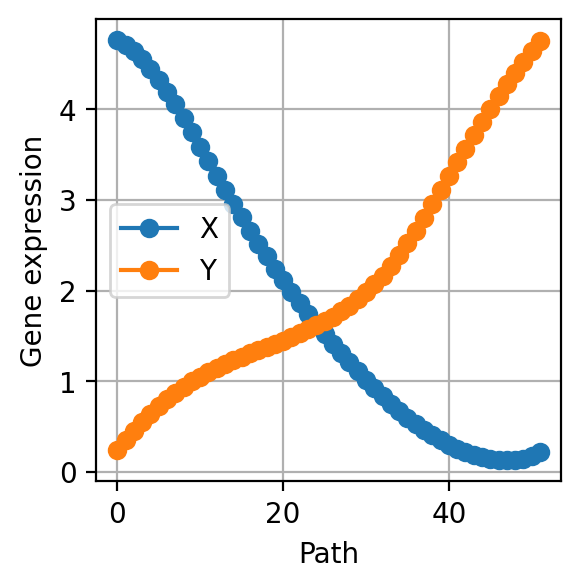

In [51]:
fig=plt.figure(figsize=(3, 3))

plt.ylabel('Gene expression')
plt.xlabel('Path')
plt.plot(df['X'], marker='o', label='X')
plt.plot(df['Y'], marker='o', label='Y')
#plt.title('Action Along 1->2 LAPs')
plt.grid(True)
plt.legend()
plt.savefig('/home/datadisk/zlg/singlecell/stemcell_cycle_differentiation/figure/gene_lap.pdf')
plt.show()

### Plotting the action values and integrals along path

In [24]:
transition_graph["A->B"]['LAP_umap']['action']

[array([ 0.        ,  0.5127248 ,  1.10400117,  1.77909546,  2.52650898,
         3.32258428,  4.14342173,  4.97567248,  5.81754069,  6.66961796,
         7.52384349,  8.36277175,  9.17219902,  9.95176899, 10.7101581 ,
        11.45226824, 12.17236762, 12.85785898, 13.49856468, 14.09315412,
        14.64865512, 15.17523183, 15.6806413 , 16.16736626, 16.63310644,
        17.0734687 , 17.48486651, 17.86613692, 18.21864232, 18.54556329,
        18.85117266, 19.14037282, 19.41825252, 19.68931424, 19.95646638,
        20.22046107, 20.48036327, 20.73456604, 20.98109922, 21.21681934,
        21.43648425, 21.63292711, 21.79866464, 21.92837958, 22.02128491,
        22.08249241, 22.12325591, 22.1607818 , 22.21861323, 22.32857894,
        22.5356093 , 22.90772979])]

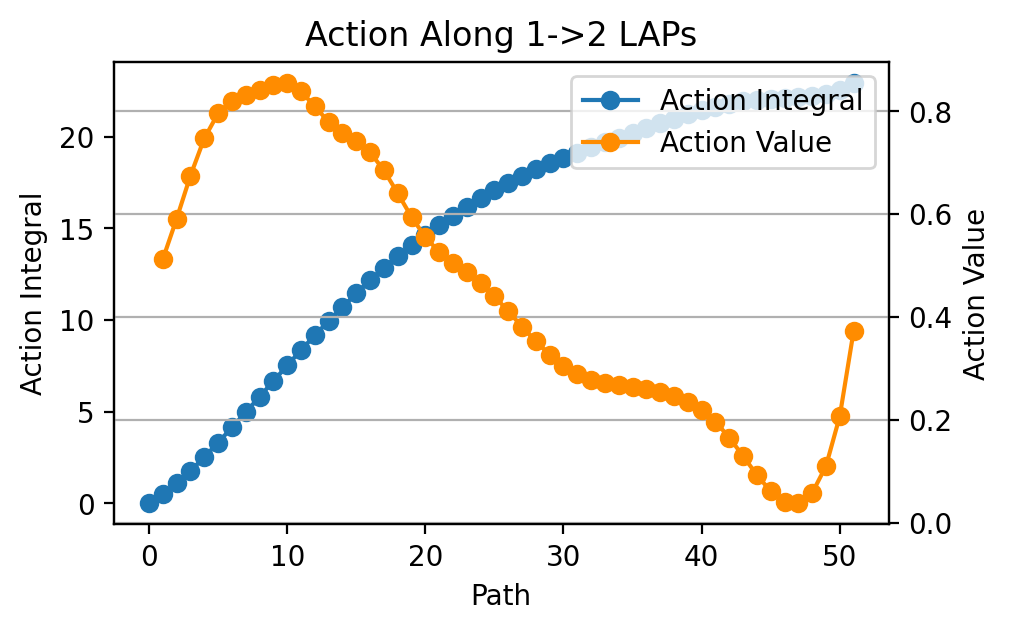

In [32]:
# Plotting the provided array of action values
import matplotlib.pyplot as plt
umap_action_integrals = np.array([ 0.        ,  0.5127248 ,  1.10400117,  1.77909546,  2.52650898,
         3.32258428,  4.14342173,  4.97567248,  5.81754069,  6.66961796,
         7.52384349,  8.36277175,  9.17219902,  9.95176899, 10.7101581 ,
        11.45226824, 12.17236762, 12.85785898, 13.49856468, 14.09315412,
        14.64865512, 15.17523183, 15.6806413 , 16.16736626, 16.63310644,
        17.0734687 , 17.48486651, 17.86613692, 18.21864232, 18.54556329,
        18.85117266, 19.14037282, 19.41825252, 19.68931424, 19.95646638,
        20.22046107, 20.48036327, 20.73456604, 20.98109922, 21.21681934,
        21.43648425, 21.63292711, 21.79866464, 21.92837958, 22.02128491,
        22.08249241, 22.12325591, 22.1607818 , 22.21861323, 22.32857894,
        22.5356093 , 22.90772979])

umap_action_values = np.diff(umap_action_integrals)
# Creating the plot
fig=plt.figure(figsize=(5, 3))
ax1 = fig.add_subplot(111)
line1, = ax1.plot(umap_action_integrals, marker='o', label='Action Integral')
ax1.set_ylabel('Action Integral')
ax1.set_xlabel('Path')
ax2 = ax1.twinx()
line2, = ax2.plot(np.linspace(1,51,51), umap_action_values, color='darkorange', marker='o', label='Action Value')
plt.title('Action Along 1->2 LAPs')
ax2.set_ylabel('Action Value')
plt.grid(True)
plt.legend(handles = [line1, line2])
plt.savefig('/home/datadisk/zlg/singlecell/stemcell_cycle_differentiation/figure/toggle_action.pdf')
plt.show()

In [25]:
transition_graph["B->A"]['LAP_umap']['action']

[array([ 0.        ,  0.43340631,  0.93899407,  1.53066298,  2.20537262,
         2.94314322,  3.71625813,  4.50290656,  5.29468702,  6.09244102,
         6.89481985,  7.68889313,  8.45146581,  9.16161107,  9.81306093,
        10.41585811, 10.98863563, 11.54863358, 12.10417325, 12.65188137,
        13.17970885, 13.67404373, 14.12639337, 14.53592026, 14.90779546,
        15.24977829, 15.56923568, 15.87157082, 16.16005007, 16.43648511,
        16.70206684, 16.95790919, 17.20539078, 17.44661799, 17.68488315,
        17.92430041, 18.16769277, 18.41294663, 18.65077951, 18.86814551,
        19.05582169, 19.2124391 , 19.34187698, 19.44836108, 19.53385993,
        19.59938265, 19.6491541 , 19.69487838, 19.75826288, 19.8731785 ,
        20.09085457, 20.49195528])]

In [34]:
transition_graph["B->A"]['LAP_umap']['prediction']

[array([[0.22253251, 4.75044716],
        [0.33219982, 4.71181145],
        [0.43498899, 4.64699395],
        [0.53011594, 4.55762443],
        [0.61746151, 4.44716428],
        [0.69781251, 4.32024937],
        [0.77255787, 4.18150682],
        [0.84279502, 4.03440302],
        [0.90852381, 3.88089681],
        [0.96871718, 3.72212525],
        [1.02237532, 3.5595566 ],
        [1.06975562, 3.39568082],
        [1.11265599, 3.23366483],
        [1.15345909, 3.07624647],
        [1.19382661, 2.92475604],
        [1.23408344, 2.77894175],
        [1.27351982, 2.63755995],
        [1.31118587, 2.49925977],
        [1.34666857, 2.36331379],
        [1.38050372, 2.22991748],
        [1.41406973, 2.09997323],
        [1.44906418, 1.97452611],
        [1.48690703, 1.85421418],
        [1.5284209 , 1.73904038],
        [1.57389472, 1.6285065 ],
        [1.6234001 , 1.52193278],
        [1.6771621 , 1.41875884],
        [1.73582364, 1.3187071 ],
        [1.8004997 , 1.22178265],
        [1.872

In [52]:
path_B_A = np.array([[0.22253251, 4.75044716],
        [0.33219982, 4.71181145],
        [0.43498899, 4.64699395],
        [0.53011594, 4.55762443],
        [0.61746151, 4.44716428],
        [0.69781251, 4.32024937],
        [0.77255787, 4.18150682],
        [0.84279502, 4.03440302],
        [0.90852381, 3.88089681],
        [0.96871718, 3.72212525],
        [1.02237532, 3.5595566 ],
        [1.06975562, 3.39568082],
        [1.11265599, 3.23366483],
        [1.15345909, 3.07624647],
        [1.19382661, 2.92475604],
        [1.23408344, 2.77894175],
        [1.27351982, 2.63755995],
        [1.31118587, 2.49925977],
        [1.34666857, 2.36331379],
        [1.38050372, 2.22991748],
        [1.41406973, 2.09997323],
        [1.44906418, 1.97452611],
        [1.48690703, 1.85421418],
        [1.5284209 , 1.73904038],
        [1.57389472, 1.6285065 ],
        [1.6234001 , 1.52193278],
        [1.6771621 , 1.41875884],
        [1.73582364, 1.3187071 ],
        [1.8004997 , 1.22178265],
        [1.8725909 , 1.12814708],
        [1.95343416, 1.03794349],
        [2.0439729 , 0.9511678 ],
        [2.1446434 , 0.8676667 ],
        [2.25553873, 0.78727856],
        [2.37668516, 0.71003369],
        [2.50811591, 0.63625617],
        [2.64950018, 0.56644513],
        [2.79944576, 0.50099106],
        [2.95514117, 0.44001365],
        [3.11307821, 0.38358998],
        [3.27049136, 0.33217482],
        [3.42612468, 0.28665694],
        [3.57974759, 0.24788835],
        [3.73115975, 0.21612492],
        [3.8795512 , 0.19088463],
        [4.02357184, 0.17137695],
        [4.16196191, 0.15726032],
        [4.29416052, 0.14928951],
        [4.42030883, 0.14955869],
        [4.5405984 , 0.16136558],
        [4.65435871, 0.18889316],
        [4.75927026, 0.23688076]])

# Convert to a DataFrame
df = pd.DataFrame(path_B_A, columns=['X', 'Y'])

# Save to a CSV file
df.to_csv('/home/datadisk/zlg/singlecell/stemcell_cycle_differentiation/toggle/path_coordinates_2.csv', index=False)

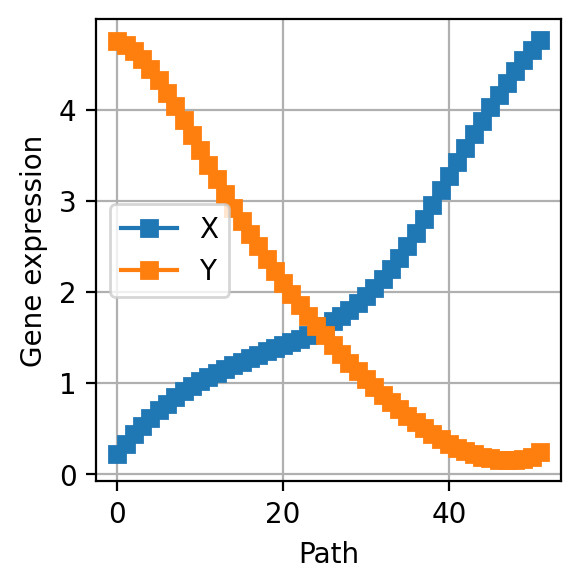

In [53]:
fig=plt.figure(figsize=(3, 3))

plt.ylabel('Gene expression')
plt.xlabel('Path')
plt.plot(df['X'], marker='s', label='X')
plt.plot(df['Y'], marker='s', label='Y')
#plt.title('Action Along 1->2 LAPs')
plt.grid(True)
plt.legend()
plt.savefig('/home/datadisk/zlg/singlecell/stemcell_cycle_differentiation/figure/gene_lap1.pdf')
plt.show()

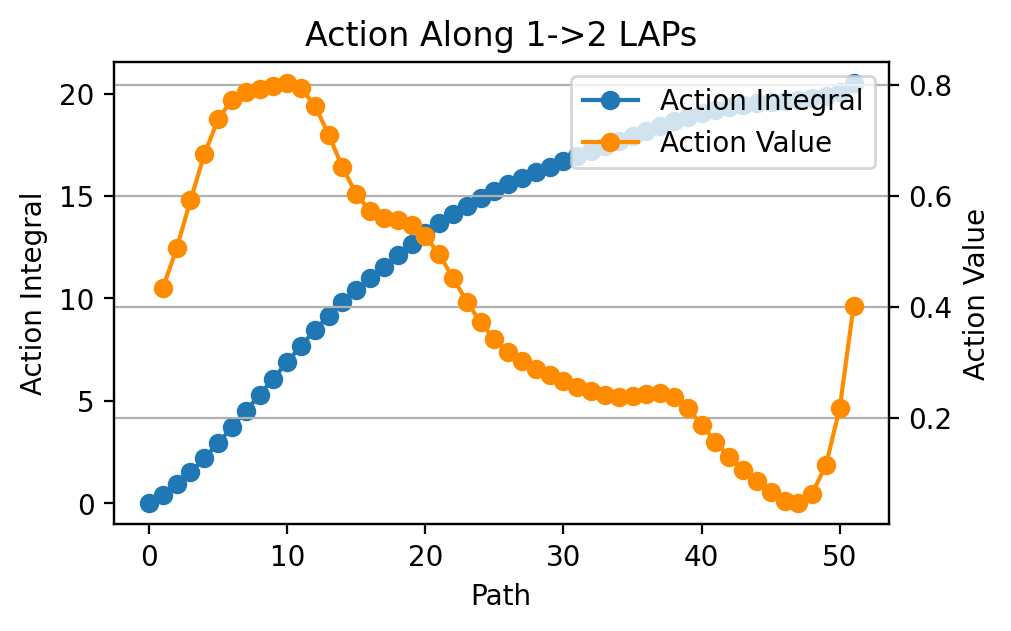

In [33]:
# Plotting the provided array of action values
import matplotlib.pyplot as plt
umap_action_integrals = np.array([ 0.        ,  0.43340631,  0.93899407,  1.53066298,  2.20537262,
         2.94314322,  3.71625813,  4.50290656,  5.29468702,  6.09244102,
         6.89481985,  7.68889313,  8.45146581,  9.16161107,  9.81306093,
        10.41585811, 10.98863563, 11.54863358, 12.10417325, 12.65188137,
        13.17970885, 13.67404373, 14.12639337, 14.53592026, 14.90779546,
        15.24977829, 15.56923568, 15.87157082, 16.16005007, 16.43648511,
        16.70206684, 16.95790919, 17.20539078, 17.44661799, 17.68488315,
        17.92430041, 18.16769277, 18.41294663, 18.65077951, 18.86814551,
        19.05582169, 19.2124391 , 19.34187698, 19.44836108, 19.53385993,
        19.59938265, 19.6491541 , 19.69487838, 19.75826288, 19.8731785 ,
        20.09085457, 20.49195528])

umap_action_values = np.diff(umap_action_integrals)
# Creating the plot
fig=plt.figure(figsize=(5, 3))
ax1 = fig.add_subplot(111)
line1, = ax1.plot(umap_action_integrals, marker='o', label='Action Integral')
ax1.set_ylabel('Action Integral')
ax1.set_xlabel('Path')
ax2 = ax1.twinx()
line2, = ax2.plot(np.linspace(1,51,51), umap_action_values, color='darkorange', marker='o', label='Action Value')
plt.title('Action Along 1->2 LAPs')
ax2.set_ylabel('Action Value')
plt.grid(True)
plt.legend(handles = [line1, line2])
plt.savefig('/home/datadisk/zlg/singlecell/stemcell_cycle_differentiation/figure/toggle_actions.pdf')
plt.show()